<a href="https://colab.research.google.com/github/alexlehner3868/TrojanDetectionInNeuralNetworks/blob/Jas/TrojanDetection_imageclassifier_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**bold text**# Set Up

In [ ]:
# Imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

In [ ]:
#!pip install --upgrade pip
#!pip install --no-cache-dir pandas scikit-learn


# Import and Process Data Helper Funtions

In [ ]:
# Calculate the mean and standard deviation per-channel
def compute_mean_std(dataset, batch_size=512):
  # Create DataLoader
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

  mean = torch.zeros(3)
  std = torch.zeros(3)
  num_pixels = 0

  # Loop over batches (x = batch of images)
  for x, _ in loader:
    # Unpack dimension: (Batch size, num channels=3, width=32, height=32)
    num_samples_in_batch, _, height, width = x.shape
    # Count number of pixels
    num_pixels += num_samples_in_batch * height * width
    # Sum over each channel (compute the numerators for mean and std)
    mean += x.sum(dim=(0, 2, 3))
    std += (x ** 2).sum(dim=(0, 2, 3))

  # Compute the mean and standard deviations
  mean /= num_pixels
  std = torch.sqrt(std / num_pixels - mean ** 2)

  return mean.tolist(), std.tolist()

# Function to load and split the dataset
def load_and_split_cifar10(data_root="./data", val_split=0.16, seed=42):

  base_transform = transforms.ToTensor()

  # Load the training dataset (without normalization)
  train_full_original = datasets.CIFAR10(root=data_root, train=True, download=True, transform=base_transform)

  # Calculate the mean and standard deviation on the training set
  mean, std = compute_mean_std(train_full_original)

  # Construct the transform with normalization # Changed to include data augmentation to imppovre model robustness
  train_transform = transforms.Compose([
      transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)
  ])

  test_transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=mean, std=std)
  ])


  # Load datasets with normalization
  train_full = datasets.CIFAR10(
      root=data_root,
      train=True,
      download=False,
      transform=train_transform
  )

  test_set = datasets.CIFAR10(
      root=data_root,
      train=False,
      download=True,
      transform=test_transform
  )


  # Create validation set from the training dataset
  val_size = int(len(train_full) * val_split)
  train_size = len(train_full) - val_size
  g = torch.Generator().manual_seed(seed)
  train_set, val_set = random_split(train_full, [train_size, val_size], generator=g)

  return train_set, val_set, test_set, mean, std


In [ ]:
# Function to process the data and generate the data loaders
def process_data(batch_size=256, val_split=0.16,poison=False, plot_distribution=True):
  # Load dataset and create splits
  train_set, val_set, test_set, mean, std = load_and_split_cifar10(val_split=val_split)

  if plot_distribution:
    plot_class_distribution(train_set, "Training set")
    plot_class_distribution(val_set, "Validation set")
    plot_class_distribution(test_set, "Test set")

  if poison:
      print("CALL FUNCTION TO POISON THE DATA")
      if plot_distribution:
        plot_class_distribution(train_set, "Training set - Poisoned")
        plot_class_distribution(val_set, "Validation set - Poisoned")
        plot_class_distribution(test_set, "Test set -  Poisoned")


  # Create DataLoaders from datasets
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
  test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

  print(f"Computed normalization stats:")
  print(f"Mean: {mean}")
  print(f"Std:  {std}")

  return train_loader, val_loader, test_loader

# Graphing Helper Functions

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Subset

CIFAR10_CLASSES = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

def plot_class_distribution(dataset, title):
    # Get labels
    if isinstance(dataset, Subset):
        labels = [dataset.dataset.targets[i] for i in dataset.indices]
    else:
        labels = dataset.targets

    # Get counts per category
    counts = torch.bincount(torch.tensor(labels), minlength=len(CIFAR10_CLASSES))

    plt.figure(figsize=(10, 4))
    plt.bar(CIFAR10_CLASSES, counts)
    plt.ylabel("Number of samples")
    plt.title(title)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


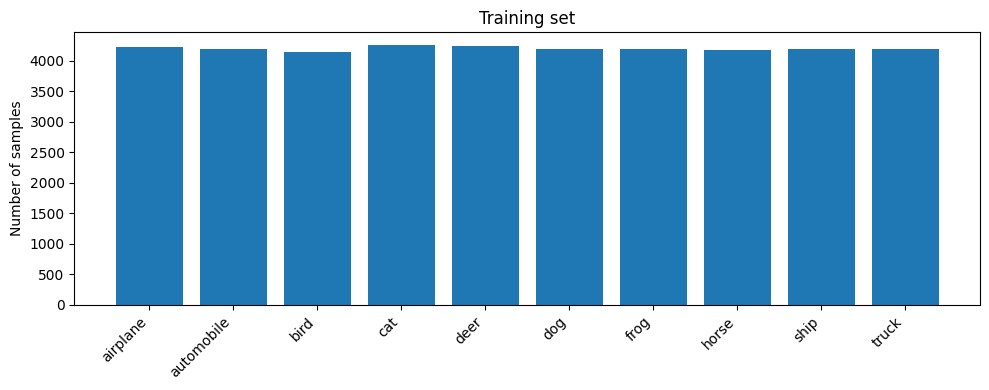

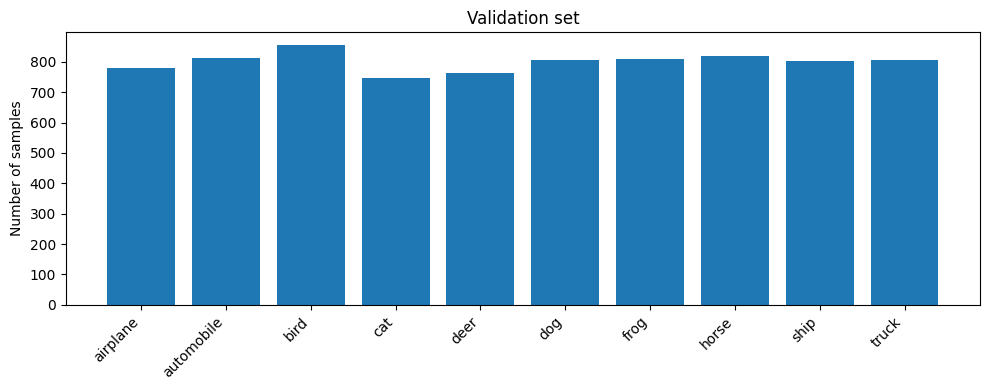

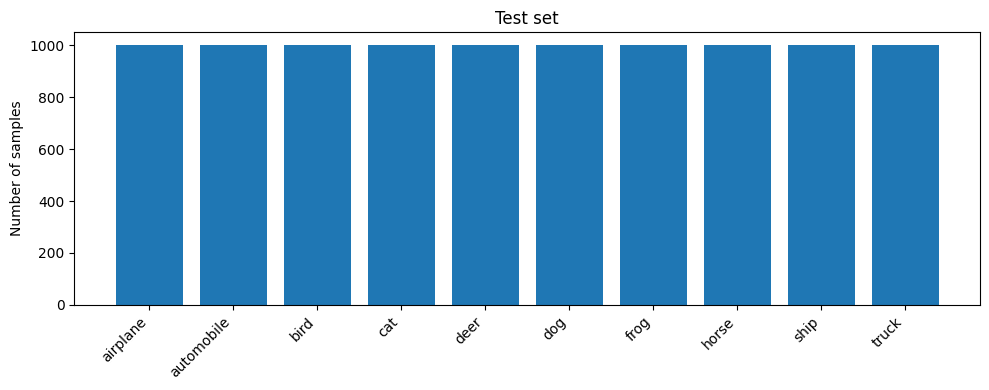

Computed normalization stats:
Mean: [0.4913996756076813, 0.48215851187705994, 0.4465310275554657]
Std:  [0.24703219532966614, 0.24348489940166473, 0.2615877091884613]


In [ ]:
# Get dataloader for each dataset
train_loader, val_loader, test_loader = process_data()

In [ ]:
for batch_ind, batch_data in enumerate(train_loader):
        datas, targets = batch_data
datas.shape

torch.Size([16, 3, 32, 32])

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.6f}')

# Test function
def test(model, device, loader, criterion):
    model.eval()
    test_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.long().to(device)
            output = model(data)

            test_loss += criterion(output, target).item() * data.size(0)

            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(loader.dataset)

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')

    return test_loss, accuracy, precision, recall, f1, all_targets, all_preds




Using device: cuda


In [ ]:
"""
    The following ResNet implementations are the official version of Pytorch library
    https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
"""

import torch
import torch.nn as nn

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError(
                'BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)

        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

def resnet_18_cifar():
    r"""
        Modify the resnet 18 network in order to run on cifar-10 dataset

        To enhance the accuracy, the (kernel_size, stride, padding) of conv1 is modified to (3, 1, 1)
        referenced by <https://github.com/akamaster/pytorch_resnet_cifar10>
    """
    model = ResNet(block=BasicBlock, layers=[2, 2, 2, 2], num_classes=10)

    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1,
                            bias=False)

    return model


In [ ]:
model = resnet_18_cifar().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # minimize validation loss
    factor=0.5,        # LR ← LR * 0.5
    patience=5,        # wait 5 epochs without improvement

    min_lr=1e-6
)



Epoch 1/128
Train Epoch: 0 [0/42000] Loss: 2.349442
Train Epoch: 0 [25600/42000] Loss: 1.532093
Val Loss: 1.5024 | Acc: 0.4541 | LR: 1.000000e-02

Epoch 2/128
Train Epoch: 1 [0/42000] Loss: 1.475035
Train Epoch: 1 [25600/42000] Loss: 1.236729
Val Loss: 1.4093 | Acc: 0.5079 | LR: 1.000000e-02

Epoch 3/128
Train Epoch: 2 [0/42000] Loss: 1.229288
Train Epoch: 2 [25600/42000] Loss: 1.072110
Val Loss: 1.1071 | Acc: 0.6042 | LR: 1.000000e-02

Epoch 4/128
Train Epoch: 3 [0/42000] Loss: 1.014107
Train Epoch: 3 [25600/42000] Loss: 0.968697
Val Loss: 1.0364 | Acc: 0.6282 | LR: 1.000000e-02

Epoch 5/128
Train Epoch: 4 [0/42000] Loss: 0.998461
Train Epoch: 4 [25600/42000] Loss: 0.861567
Val Loss: 0.9656 | Acc: 0.6633 | LR: 1.000000e-02

Epoch 6/128
Train Epoch: 5 [0/42000] Loss: 0.803545
Train Epoch: 5 [25600/42000] Loss: 0.797702
Val Loss: 0.8417 | Acc: 0.7034 | LR: 1.000000e-02

Epoch 7/128
Train Epoch: 6 [0/42000] Loss: 0.752790
Train Epoch: 6 [25600/42000] Loss: 0.807211
Val Loss: 0.7494 | Ac

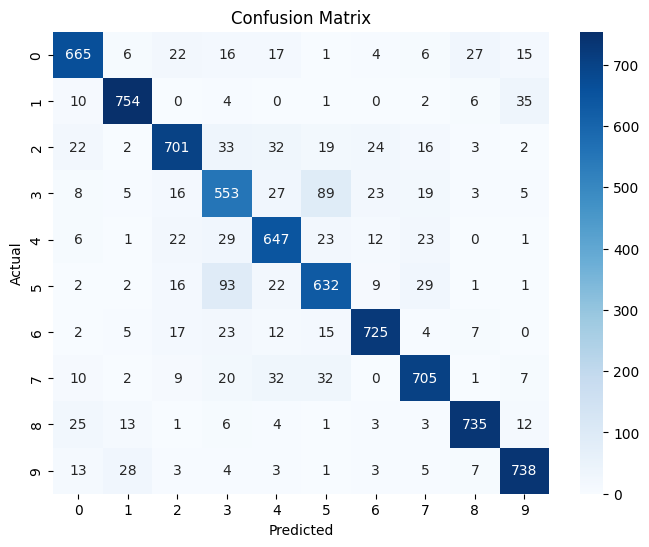

In [ ]:
num_epochs = 128

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train(model, device, train_loader, optimizer, criterion, epoch)

    val_loss, val_acc, val_prec, val_rec, val_f1, y_true, y_pred = test(
        model, device, val_loader, criterion
    )

    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(
        f"Val Loss: {val_loss:.4f} | "
        f"Acc: {val_acc:.4f} | "
        f"LR: {current_lr:.6e}"
    )

    # Only visualize on LAST epoch
    if epoch == num_epochs - 1:
        print("\nFinal Evaluation")
        print(classification_report(y_true, y_pred))

        cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
